In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys

In [2]:
sys.path.append(os.path.abspath('/home/olani/Documents/kifiya/week10/Brent-oil-prices-analysis'))
from brent_analysis.data.load_data import load_brent_data

In [4]:
data_path = '/home/olani/Documents/kifiya/week10/Brent-oil-prices-analysis/brent_analysis/data/row/Copy_of_BrentOilPrices.csv' 
df = load_brent_data(data_path)

/home/olani/Documents/kifiya/week10/Brent-oil-prices-analysis/brent_analysis/data/load_data.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(filepath, parse_dates=['Date'], dayfirst=True)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9011 non-null   datetime64[ns]
 1   Price   9011 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 140.9 KB


In [6]:
df.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


### Price Trend Over Time

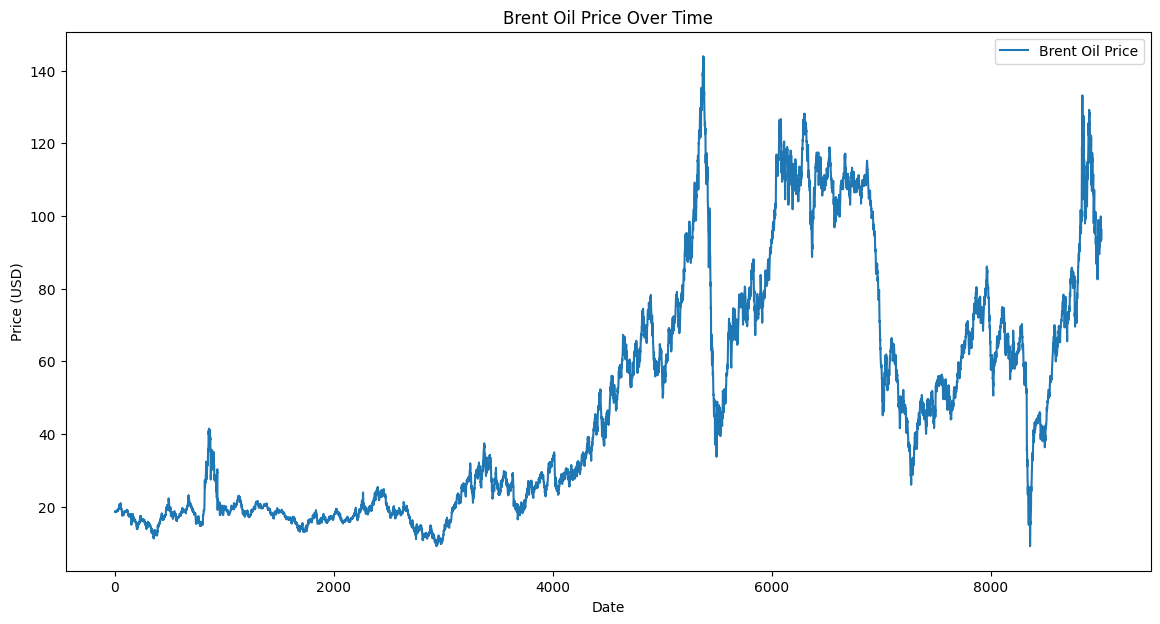

In [7]:
# Line plot for price trends over time
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Price'], label='Brent Oil Price')
plt.title('Brent Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

### Seasonal Decomposition

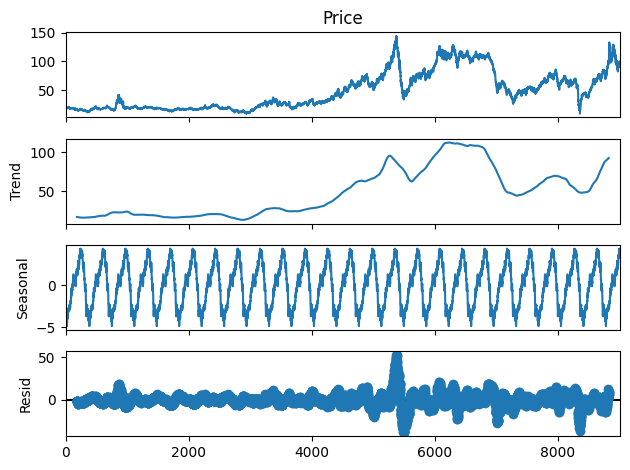

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose time series
decomposition = seasonal_decompose(df['Price'], model='additive', period=365)
decomposition.plot()
plt.show()

### Rolling Statistics

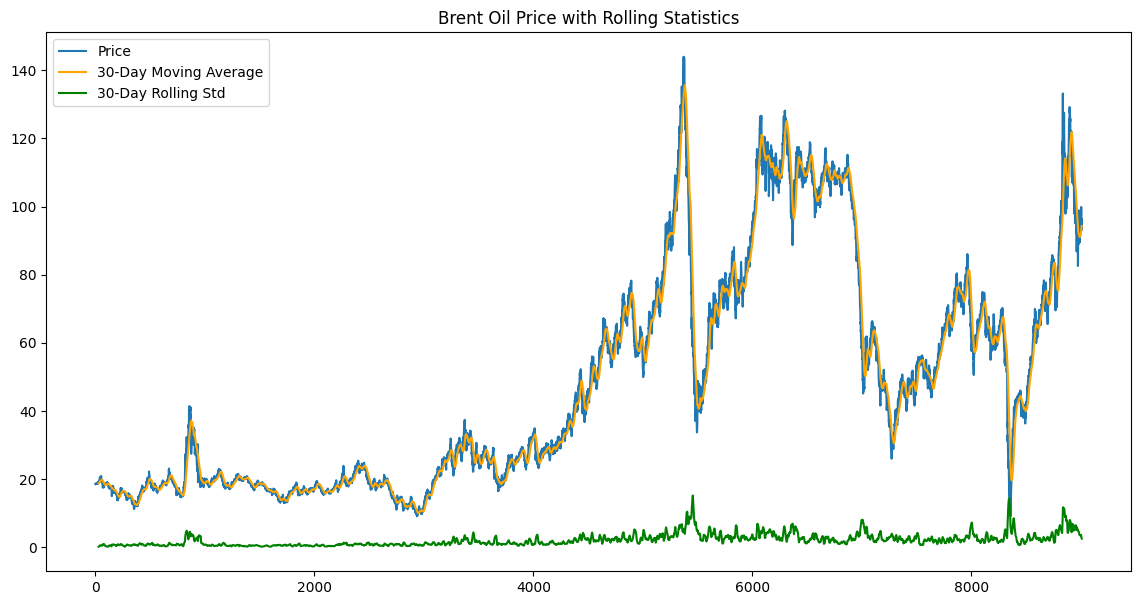

In [9]:
# Rolling statistics (e.g., 30-day moving average)
df['Rolling_Mean'] = df['Price'].rolling(window=30).mean()
df['Rolling_Std'] = df['Price'].rolling(window=30).std()

plt.figure(figsize=(14, 7))
plt.plot(df['Price'], label='Price')
plt.plot(df['Rolling_Mean'], label='30-Day Moving Average', color='orange')
plt.plot(df['Rolling_Std'], label='30-Day Rolling Std', color='green')
plt.title('Brent Oil Price with Rolling Statistics')
plt.legend()
plt.show()

### Stationarity Check

In [10]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(df['Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.9938560113924666
p-value: 0.2892735048934033


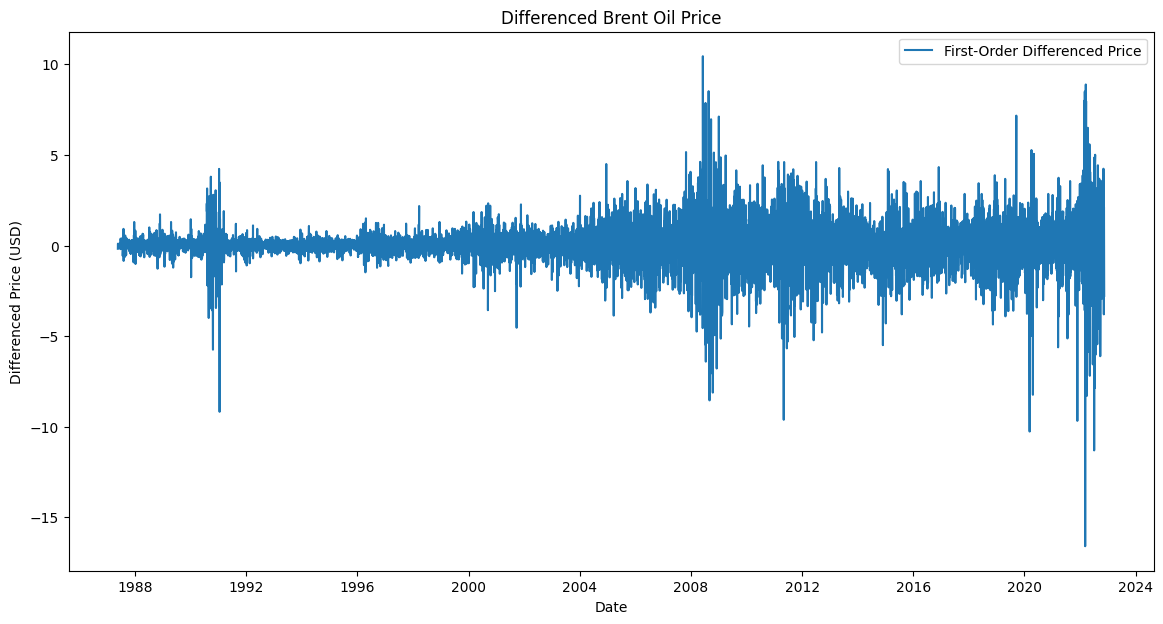

In [11]:
# Apply first-order differencing to make the series stationary
df['Price_diff'] = df['Price'].diff()

# Plot the differenced series
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Price_diff'], label='First-Order Differenced Price')
plt.title('Differenced Brent Oil Price')
plt.xlabel('Date')
plt.ylabel('Differenced Price (USD)')
plt.legend()
plt.show()

In [12]:
# Drop NA values caused by differencing
price_diff = df['Price_diff'].dropna()

# Perform ADF test on differenced series
result_diff = adfuller(price_diff)
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])

ADF Statistic (Differenced): -15.529367580048003
p-value (Differenced): 2.23074051051641e-28


## Set Up and Fit the ARIMA Model

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# Define and fit the ARIMA model
model = ARIMA(df['Price'], order=(1, 1, 1))
arima_result = model.fit()

# Display the model summary
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14543.950
Date:                Sat, 02 Nov 2024   AIC                          29093.899
Time:                        11:31:18   BIC                          29115.218
Sample:                             0   HQIC                         29101.153
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3427      0.159     -2.152      0.031      -0.655      -0.031
ma.L1          0.3712      0.157      2.358      0.018       0.063       0.680
sigma2         1.4777      0.008    184.571      0.0

### Plot the Model Fit

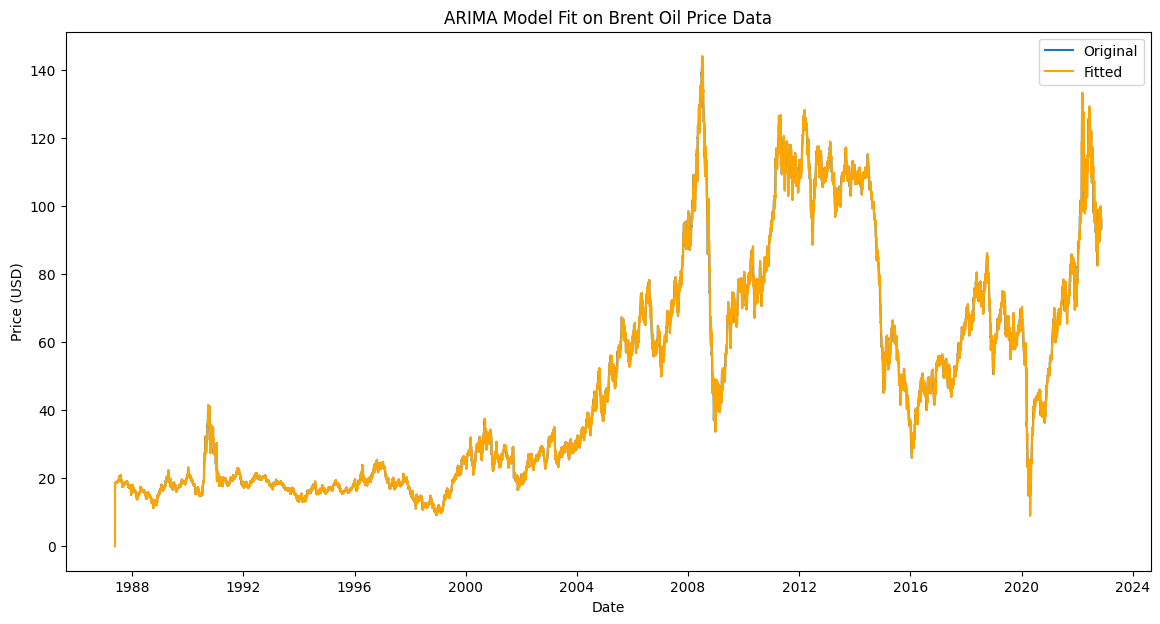

In [14]:
# Plotting the original data vs. fitted values
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Price'], label='Original')
plt.plot(df['Date'], arima_result.fittedvalues, color='orange', label='Fitted')
plt.title('ARIMA Model Fit on Brent Oil Price Data')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

### Forecasting Future Prices

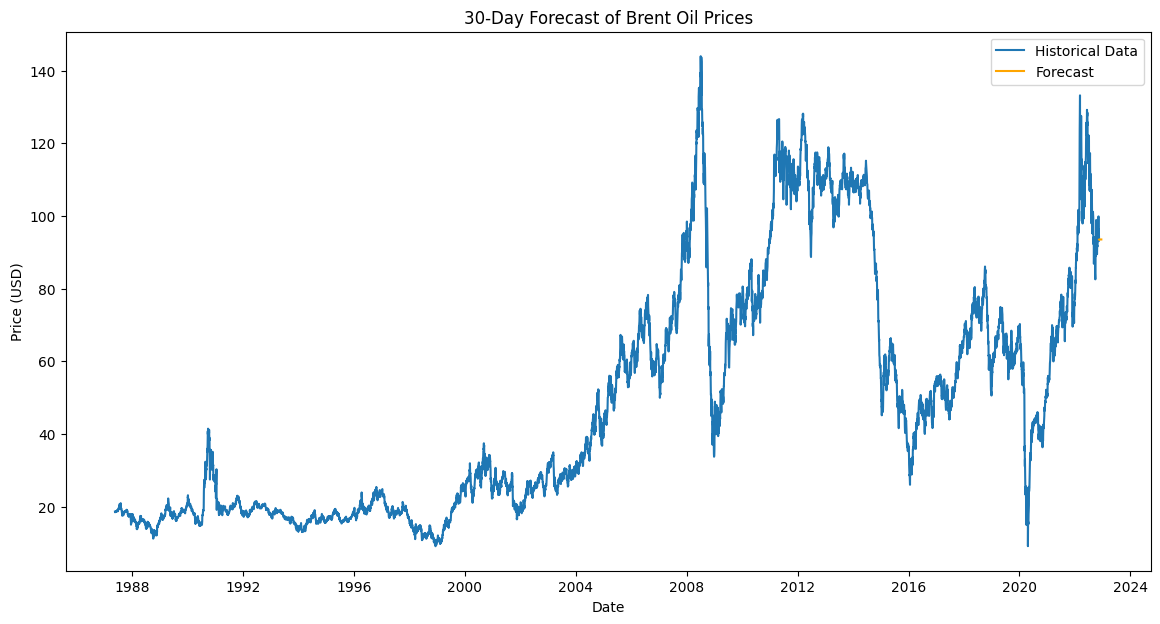

In [15]:
# Forecasting the next 30 days
forecast = arima_result.forecast(steps=30)

# Plot the forecast along with the historical data
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Price'], label='Historical Data')
forecast_dates = pd.date_range(df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=30)
plt.plot(forecast_dates, forecast, color='orange', label='Forecast')
plt.title('30-Day Forecast of Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

### Model Evaluation

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming we have the last 30 days as actual values for testing
y_true = df['Price'][-30:]
y_pred = forecast[:30]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 2.042399744371806
Root Mean Squared Error (RMSE): 2.6201762063005236
